# Basic Modelling with ISOSIMpy

In [8]:
import ISOSIMpy.model as ism
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

## 1. Load (Synthetic) Observation Data
See Example 3 on how this data is generated.

In [9]:
# load input series
# this would be the tracer concentration in precipitation or recharge in a
# practical problem
file_name = "example_input_series.csv"
data = np.genfromtxt(
    file_name,
    delimiter=",",
    dtype=["<U7", float],
    encoding="utf-8",
    skip_header=1
)

timestamps = np.array([datetime.strptime(row[0], r"%Y-%m") for row in data])
input_series = np.array([float(row[1]) for row in data])

# load observation series
# this would be the measured tracer concentration in groudnwater in a
# practical problem
file_name = "example_observation_series.csv"
data = np.genfromtxt(
    file_name,
    delimiter=",",
    dtype=["<U7", float],
    encoding="utf-8",
    skip_header=1
)

timestamps = np.array([datetime.strptime(row[0], r"%Y-%m") for row in data])
obs_series = np.array([float(row[1]) for row in data])

# load full system output series
# this would be the true tracer concentration in groudnwater in a practical
# problem; this is not available in practice
file_name = "example_output_series.csv"
data = np.genfromtxt(
    file_name,
    delimiter=",",
    dtype=["<U7", float],
    encoding="utf-8",
    skip_header=1
)

timestamps = np.array([datetime.strptime(row[0], r"%Y-%m") for row in data])
output_series = np.array([float(row[1]) for row in data])

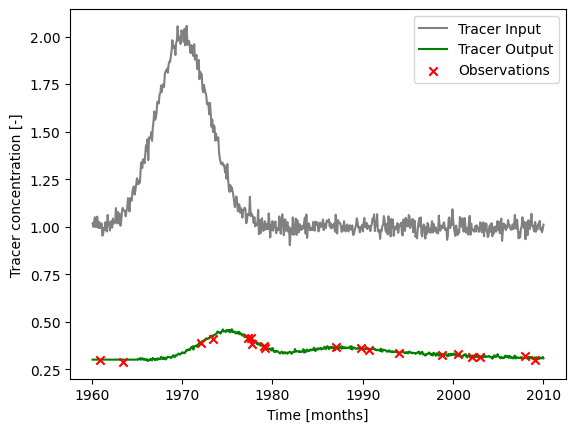

In [10]:
### plot input series, output series, and observations

# get observation timesteps
timesteps = [t.year + t.month / 12.0 for t in timestamps]

# create figure
fig, ax = plt.subplots(1, 1)
# plot input series
ax.plot(
    timesteps,
    input_series,
    label="Tracer Input",
    c="grey"
)
# plot output series
ax.plot(
    timesteps,
    output_series,
    label="Tracer Output",
    c="green"
)
# plot observations
ax.scatter(
    timesteps,
    obs_series,
    label="Observations",
    color="red",
    marker="x",
    zorder=10
)
ax.set_xlabel("Time [months]")
ax.set_ylabel("Tracer concentration [-]")
ax.legend()
plt.show()

## 2. Calibrate Model Parameters

In [11]:
t_half = 12.3 * 12.0
lambda_ = np.log(2.0) / t_half

### define model (use the same structure / units as the true model)
# time step is 1 month
m = ism.Model(
    dt=1.0,
    lambda_=lambda_,
    input_series=input_series,
    target_series=obs_series,
    steady_state_input=1., # this is the true value
    n_warmup_half_lives=10
)

# add an exponential-piston-flow unit
# define the initial model parameters for inference
epm_mtt_init = 12 * 1 # 1 year
epm_eta_init = 1.1
m.add_unit(
    ism.EPMUnit(mtt=epm_mtt_init, eta=epm_eta_init),
    fraction=.8, # 80 percent of the overall response; is the true value
    bounds=[(1.0, 12.0 * 50.), (1.0, 3.0)],
    prefix="epm"
)

# add a piston-flow unit
# define the true model parameters
pm_mtt_init = 12 * 1 # 1 year
m.add_unit(
    ism.PMUnit(mtt=pm_mtt_init),
    fraction=.2, # 20 percent of the overall response, is the true value
    bounds=[(1.0, 12.0 * 50.)],
    prefix="pm"
)

In [14]:
# create a solver
solver = ism.Solver(m)
# run DE
sol, sim = solver.differential_evolution(maxiter=100, popsize=10)

In [16]:
# define true parameters
epm_mtt_true = 12 * 40 # 40 years
epm_eta_true = 1.5
pm_mtt_true = 12 * 5 # 5 years (faster than EPM)

# print solution
print("EPM MTT (true):", epm_mtt_true, "EPM MTT (cal):", sol["epm.mtt"])
print("EPM Eta (true):", epm_eta_true, "EPM Eta (cal):", sol["epm.eta"])
print("PM MTT (true):", pm_mtt_true, "PM MTT (cal):", sol["pm.mtt"])

EPM MTT (true): 480 EPM MTT (cal): 481.8128258316174
EPM Eta (true): 1.5 EPM Eta (cal): 1.4974000809086792
PM MTT (true): 60 PM MTT (cal): 60.481218915834596


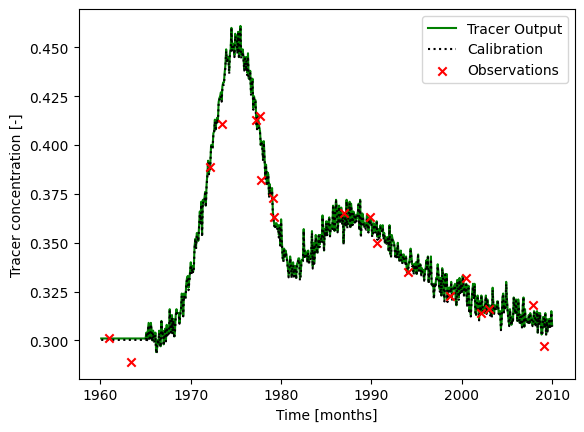

In [21]:
### plot input series, true output series, observations, and´
# calibrated output

# create figure
fig, ax = plt.subplots(1, 1)
# plot output series
ax.plot(
    timesteps,
    output_series,
    label="Tracer Output",
    c="green",
    zorder=0
)
# plot calibrated results
ax.plot(
    timesteps,
    sim,
    label="Calibration",
    c="black",
    alpha=1.,
    ls=":"
)

# plot observations
ax.scatter(
    timesteps,
    obs_series,
    label="Observations",
    color="red",
    marker="x",
    zorder=100000000
)
ax.set_xlabel("Time [months]")
ax.set_ylabel("Tracer concentration [-]")
ax.legend()
plt.show()